# Options in RL

Raphael Cohen  
sources : https://github.com/alversafa/option-critic-arch (for the code)  
          https://pierrelucbacon.com/optioncriticposter.pdf (for images)


Imagine you have a virtual house where an agent is on the top of the stairs. In order to exit of the house the agent have to go down a stairs of 120 step and then cross a coridor. You want the agent to learn how to exit. The "normal" way to exit is to teach the agent that when he is going down the stairs he has to move his right leg down the first step, then his left leg down the next step and so on until he finishies to go down the stair, then he has to walk in the corridor until he gets out of the house. 
Imagine know that we could create an encapsulated policy for the time the agent is going down the stair. This encapsulated policy is called an option. 

### formal description of an option

an option have 3 proprieties : 
- an Initiation state

<img src="img/C1.png" width="70" align='left'/>

- a Policy  π 

<img src="img/C3.png" width="170" align='left'/>

- a termination β

<img src="img/C2.png" width="120" align='left'/>

The meaning is : if the option is taken by the agent at the state St, then actions from time t are selected according to the policy  π until we get to the termination state (it will be the state where β(Sn) = 1)

Note that an action is a special case of an option where β = 1 and  π = a.

Thanks to options we can encapsulate a policy from a certain kind of state to another. In our example, we can encapsulate the policy of going down the stairs from the first step to the last step of the stairs. This will allow the agent to 'understand' than when he is meeting a stair he has to adopt a certain policy for a defined timestamp. 

<img src="img/C5.png" width="900" align='left'/>

Options are closely related to the actions in a special kind of decision problem known as a semi-Markov decision process, or SMDP

### Difference between Markov option and semi Markov option

- Markov Option : the policy π depends only on the current state 
- Semi Markov Option : the policy π depends on history since the option is started. a semi Markov option is an aggregation of a specified number of actions and terminates after a pre-defined number of timestamp. On the opposite the Markov Option policy and termination depends only of the current state (and no the states before).


any MDP with a fixed set of options is an SMDP. Because the MDP augmented by the options is an SMDP, we
can apply SMDP learning methods. 
We have to precise that in a SMDP we assume that actions have duration, so here we will replace in a MDP ations by options. 


<img src="img/C8.png" width="400"/>

### Learning with Markov Options

The principle is : when the execution of option o is started in state s, we next jump to the state s' in which o
terminates. Based on this experience, an option-value function Q(s,o) is updated.
For example, the SMDP version of one-step Q-learning updates the value function after each option termination by

<img src="img/C4.png" width="600" align='left'/>

where k denotes the number of time steps elapsing between s and s' , r denotes the cumulative discounted reward over this time, and it is implicit that the step-size parameter α may depend arbitrarily on the states, option, and time steps. 

Finding the internal policy of an option can be done using standart RL methods like Q-learning. The difficulty is how to select good termination conditions and initiation set. 

# Algorithm for finding options 

<img src="img/C6.png" width="900" align='left'/>

<img src="img/C7.png" width="900" align='left'/>

Once the options are found, we can use a Q-Learning algorithm but we use it with option instead of actions. It means that we will learn an optimal policy over options. 

### Hierarchical planning 

Option is the basis if another type of Reinforcement Learning called Hierarchical Reinforcement Learning. The main goal is to separate low level tasks from high level tasks. Lower levels tasks are a combination of multiple states that can be grouped into one option. Each option has its own policy and allow the agent to perform a lower level task. In order to perform higher level task the agent has to make choice between options and not directelly between actions. 

### Learning Options with otpion-critic Architecture 

As we understood, any learning algorithm can replace actions by options, the difficulty is to find good options that will have a good policy but also a good initial state and terminantion state. The option-critic architecture is an algorithm that can learn at the same time the global policy option of the game and also every intra-policies of options (internal policy if each options). 

We want to optimize : 
- The global option policy (higher level)
- The internal policy of options (wich actions will be choosen during the time of the option)
- the termination of options. 

Let's define Qπ(s,w) as the option value function and let's be Qu(s,w,a) the value of performing action a in the state-option pair s,w. Qu is the internal option-value function of an option, we want u to be the optimal policy for an option. 

<img src="img/C10.png" width="900" align='left'/>

<img src="img/C9.png" width="600" align='left'/>

<img src="img/C11.png" width="600" align='left'/>

## Option-Critic Architecture Implementation

Now lets create our policies.
Q_Omega is the higher level meta-policy informing the lower level policies.
Lets define our Q_Omega policy as a 2D Q table where each state has a set of options. The options direct the lower level policy on which action to take to maximize its reward. The number of options are defined by noptions. We sample from our Q_Omega table in an epsilon greedy manner.


In [1]:
from collections import defaultdict
class EpsGreedyPolicy():

    def __init__(self, rng, nstates, noptions, epsilon):
        self.rng = rng
        self.nstates = nstates
        self.noptions = noptions
        self.epsilon = epsilon
        self.Q_Omega_table = defaultdict()
    
    #return the options/ all options that are related to a state
    def Q_Omega(self, state, option=None):
        if state not in self.Q_Omega_table:
            self.Q_Omega_table[state] = np.zeros(self.noptions) #for each state we add a number of options 
        if option is None:
            return self.Q_Omega_table[state]
        else:
            return self.Q_Omega_table[state][option]            
    
    #return the option with the maximum state-option Value for a state (or choose to explore with a epsilon probability)
    def sample(self, state):
        if self.rng.uniform() < self.epsilon:
            return int(self.rng.randint(self.noptions))
        else:
            return int(np.argmax(self.Q_Omega(state)))

Lets create our lower level policy as a softmax policy called Q_U. Our Q_U table stores the actions our lower level policy takes. Here, let’s sample our actions using a softmax policy. Our update is a Bellman update.

In [2]:
class SoftmaxPolicy():
    #options policy class
    def __init__(self, rng, lr, nstates, nactions, temperature=1.0):
        self.rng = rng
        self.lr = lr
        self.nstates = nstates
        self.nactions = nactions
        self.temperature = temperature
        self.weights = defaultdict()
    
    #return all the actions that are related to a state
    def Q_U(self, state, action=None):
        if state not in self.weights:
            self.weights[state] = np.zeros(self.nactions)
        if action is None:
            return self.weights[state]
        else:
            return self.weights[state][action]
        
    #return the action with the maximum state-action value
    def pmf(self, state):
        exponent = self.Q_U(state) / self.temperature
        return np.exp(exponent - logsumexp(exponent))

    def sample(self, state):
        return int(self.rng.choice(self.nactions, p=self.pmf(state)))

    def gradient(self):
        pass
    def update(self, state, action, Q_U):
        actions_pmf = self.pmf(state)
        self.weights[state] -= self.lr * actions_pmf * Q_U
        self.weights[state][action] += self.lr * Q_U

Finally, let us define our Termination Policy. This will be used to change the option or higher level policy the lower level has been following.

In [3]:
#each time we are changing of states we ask if changing of policy at this time have a better expected reward than
#keeping this policy. If changing policy has a better reward expetancy so we update the termination of the option 
#to this state. 

class SigmoidTermination():
    def __init__(self, rng, lr, nstates):
        self.rng = rng
        self.lr = lr
        self.nstates = nstates
        self.weights = {}
    
    def pmf(self, state):
        if state not in self.weights:
            self.weights[state] = 0.0
        return expit(self.weights[state])

    def sample(self, state):
        return int(self.rng.uniform() < self.pmf(state))

    def gradient(self, state):
        return self.pmf(state) * (1.0 - self.pmf(state)), state

    def update(self, state, advantage):
        if state not in self.weights:
            self.weights[state] = 0.0
        magnitude, action = self.gradient(state)
        self.weights[action] -= self.lr * magnitude * advantage

We have our 2 levels ready. Now we will define our Critic. This is an extension of the Actor-Critic framework. Here the Critic evaluates the options and tells the higher level how good the option is. The Q_Omega i.e. the meta policy informing the intra-options policy, Q_U and Termination Policy form a part of the Option part and the Q_U i.e. value of executing an action in context of state and option, forms a part of the Critic.

In [4]:
class Critic():

    def __init__(self, lr, discount, Q_Omega_table, nstates, noptions, nactions):
        self.lr = lr
        self.discount = discount
        self.Q_Omega_table = Q_Omega_table
        self.Q_U_table = np.zeros((nstates, noptions, nactions))
        self.noptions = noptions

    def cache(self, state, option, action):
        self.last_state = state
        self.last_option = option
        self.last_action = action
        self.last_Q_Omega = self.Q_Omega(state, option)

    def Q_Omega(self, state, option=None):
        if state not in self.Q_Omega_table:
            self.Q_Omega_table[state] = np.zeros(self.noptions) #for each state we add a number of options 
        if option is None:
            return self.Q_Omega_table[state]
        else:
            return self.Q_Omega_table[state][option] 

    def Q_U(self, state, option, action):
        return self.Q_U_table[state, option, action]

    def A_Omega(self, state, option=None):
        advantage = self.Q_Omega(state) - np.max(self.Q_Omega(state))
        if option is None:
            return advantage
        else:
            return advantage[option]

    def update_Qs(self, state, option, action, reward, done, terminations):
        # One step target for Q_Omega
        target = reward
        if not done:
            beta_omega = terminations[self.last_option].pmf(state)
            target += self.discount * ((1.0 - beta_omega)*self.Q_Omega(state, self.last_option) + \
                                       beta_omega*np.max(self.Q_Omega(state)))

        # Difference update
        tderror_Q_Omega = target - self.last_Q_Omega
        self.Q_Omega_table[self.last_state][self.last_option] += self.lr * tderror_Q_Omega

        tderror_Q_U = target - self.Q_U(self.last_state, self.last_option, self.last_action)
        self.Q_U_table[self.last_state, self.last_option, self.last_action] += self.lr * tderror_Q_U

        # Cache
        self.last_state = state
        self.last_option = option
        self.last_action = action
        if not done:
            self.last_Q_Omega = self.Q_Omega(state, option)

Let's train our model with the multi taxi environement : 

In [5]:
import numpy as np
import gym
import random
from multi_taxi import MultiTaxiEnv
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multi_taxi import MultiTaxiEnv

env = MultiTaxiEnv(option_to_stand_by=False)

x = env.reset()
env.render()
print(env.observation_space)
print(x)


+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : :_: : : | : :P: : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :D| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3,2), Collided: False
Passenger1: Location: (3, 8), Destination: (6, 6)
Done: False, {'taxi_0': False, '__all__': False}
Passengers Status's: [2]
MultiDiscrete([ 7 12  7 12  7 12  4])
{'taxi_0': array([3, 2, 3, 8, 6, 6, 2])}


In [6]:
# Hyperparameters

# Discount
discount = 0.99

# Learning rates - termination, intra-option, critic
lr_term = 0.25
lr_intra = 0.25
lr_critic = 0.5

# Epsilon for epsilon-greedy for policy over options
epsilon = 1e-1

# Temperature for softmax
temperature = 1e-2

# Number of runs
nruns = 20

# Number of episodes per run
nepisodes = 1000

# Maximum number of steps per episode
nsteps = 1000

# Number of options
noptions = 2



In [7]:
def tuple_to_index(state_list,env):
    a,s,d,f,g,h,j = state_list
    A,S,D,F,G,H,J = env.vector_observation_dims
    return a + s*A + d*A*S + f*A*S*D + g*A*S*D*F + h*A*S*D*F*G + j*A*S*D*F*G*H

  0%|          | 0/20000000 [00:00<?, ?it/s]

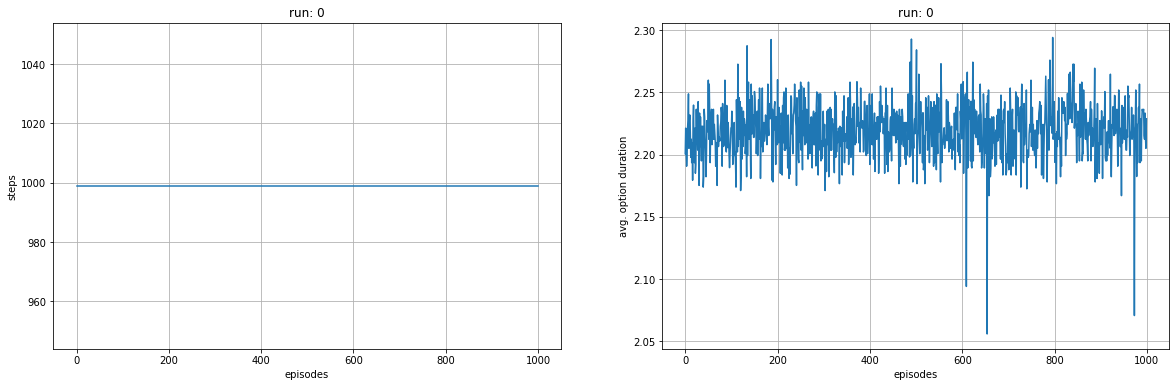

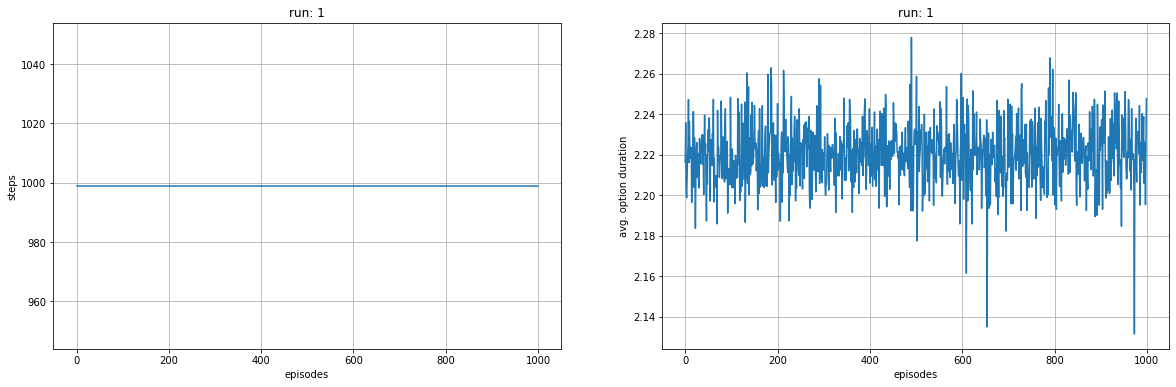

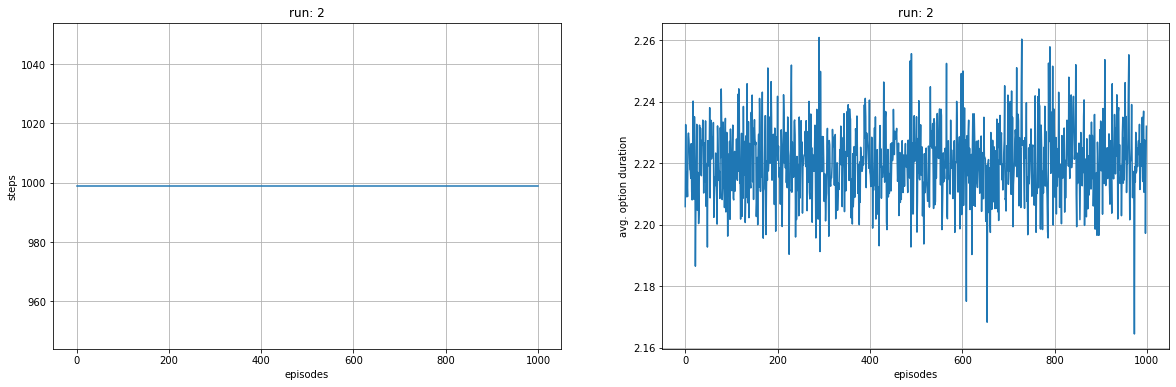

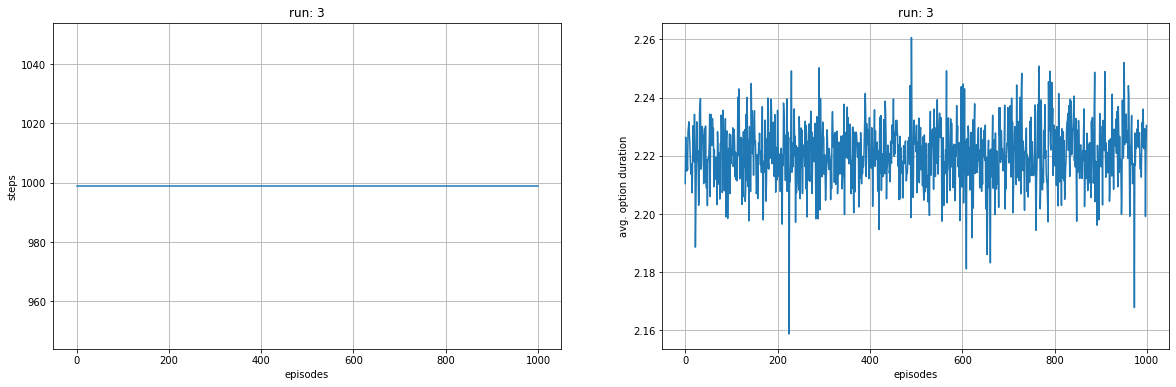

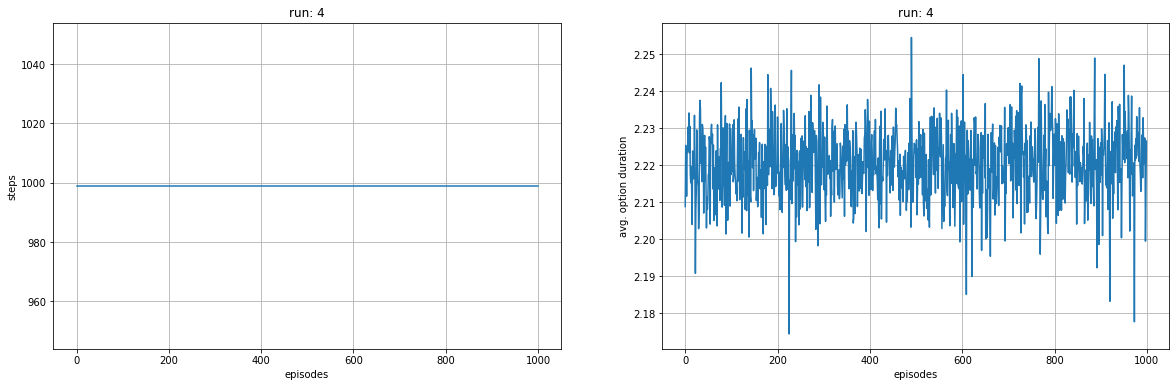

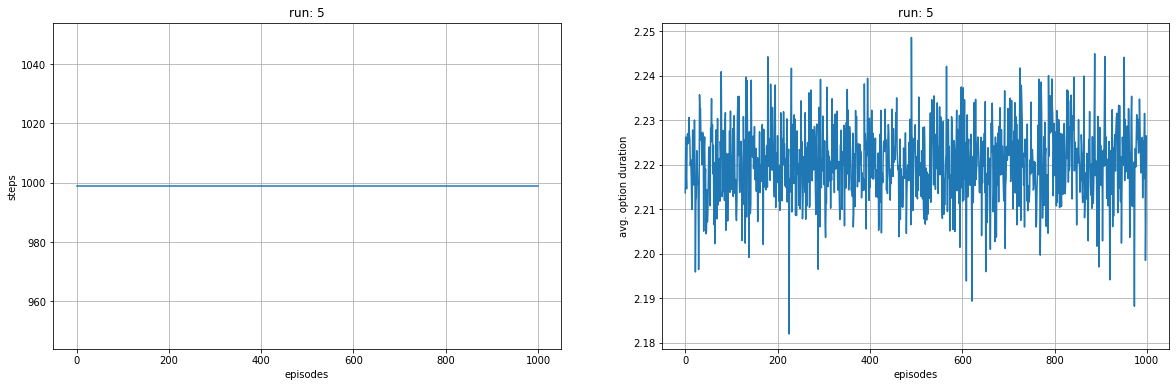

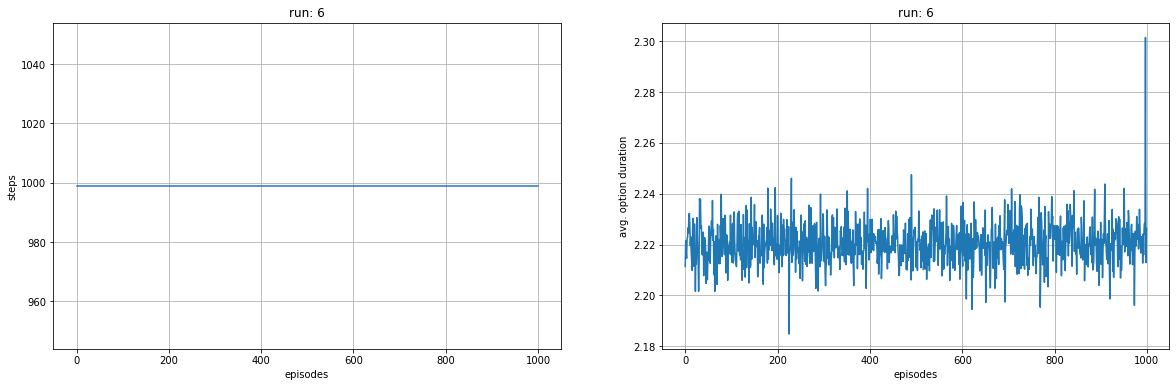

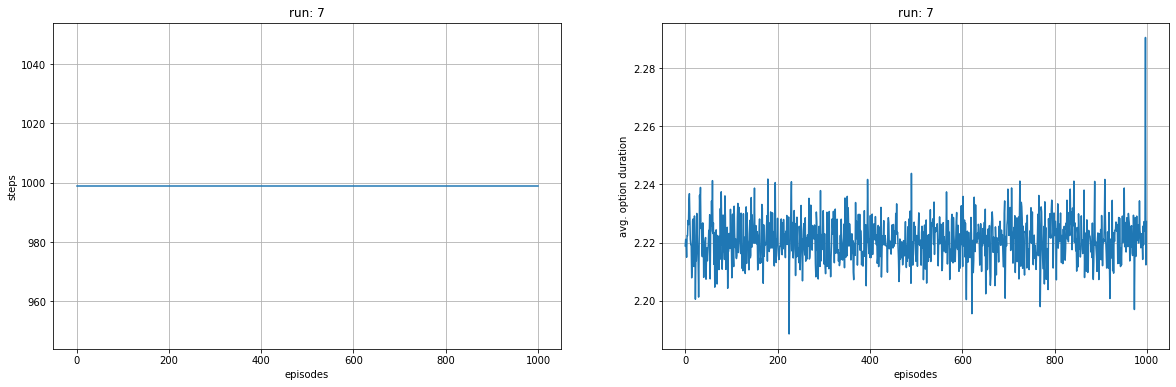

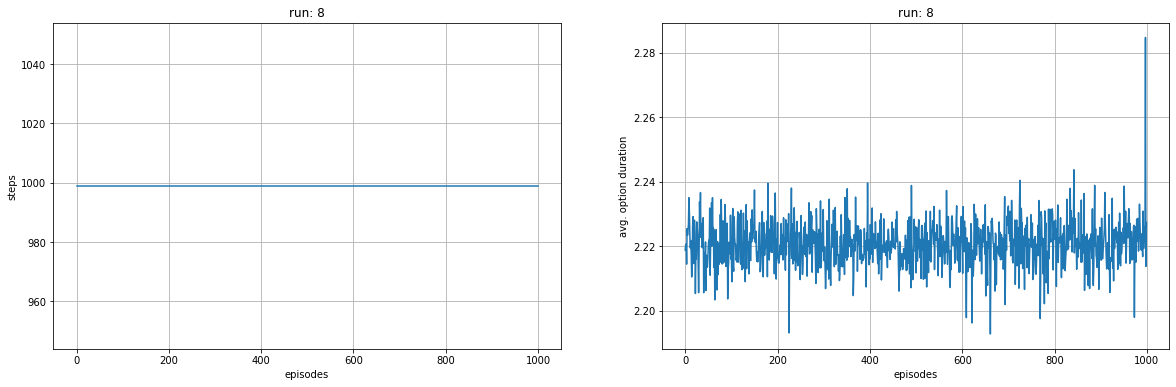

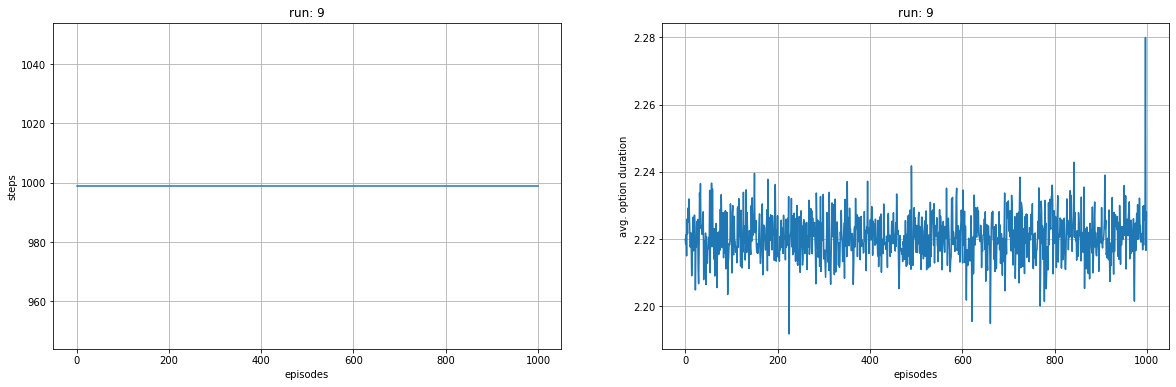

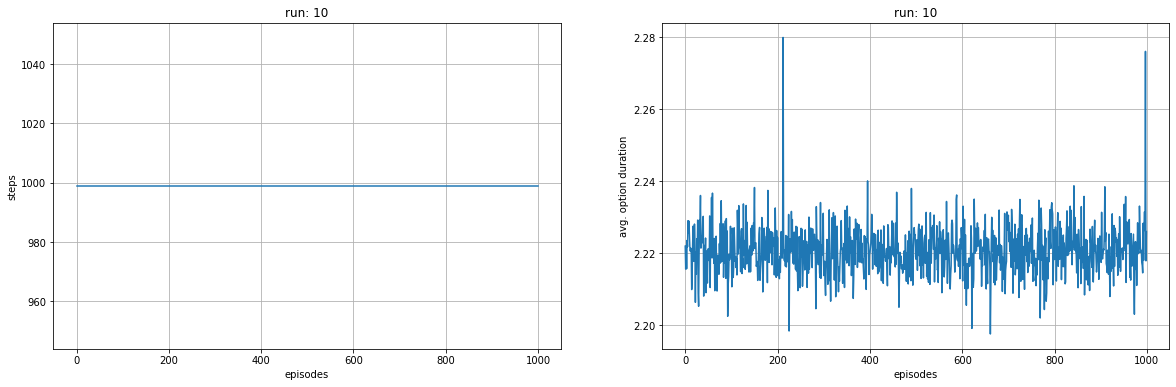

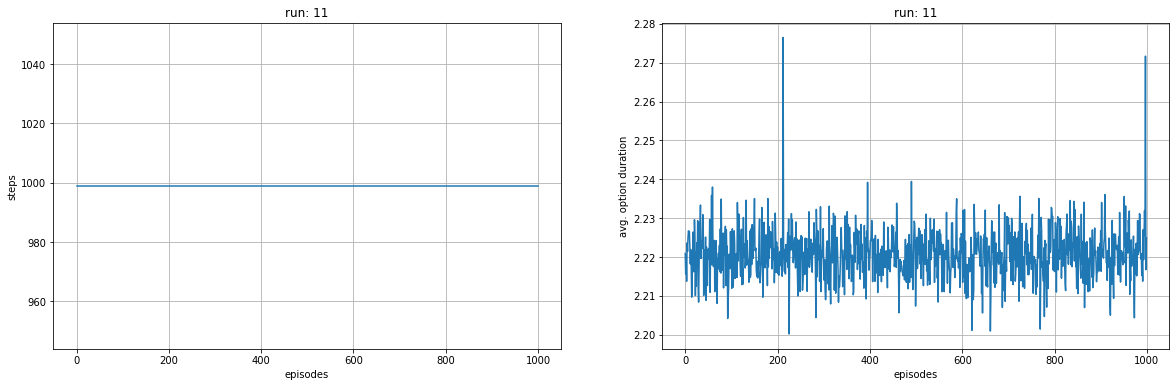

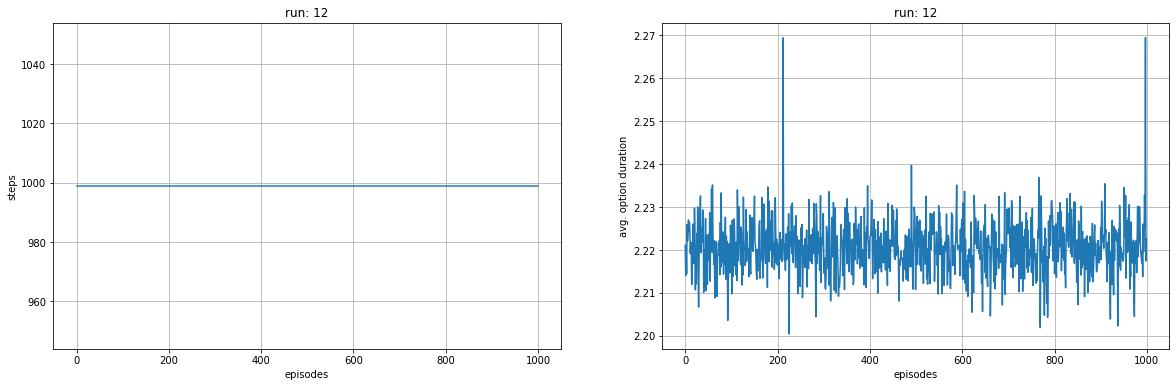

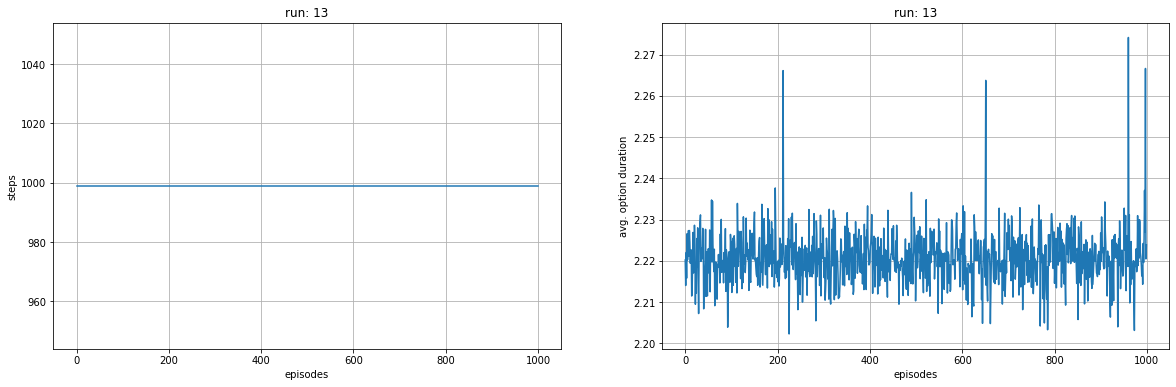

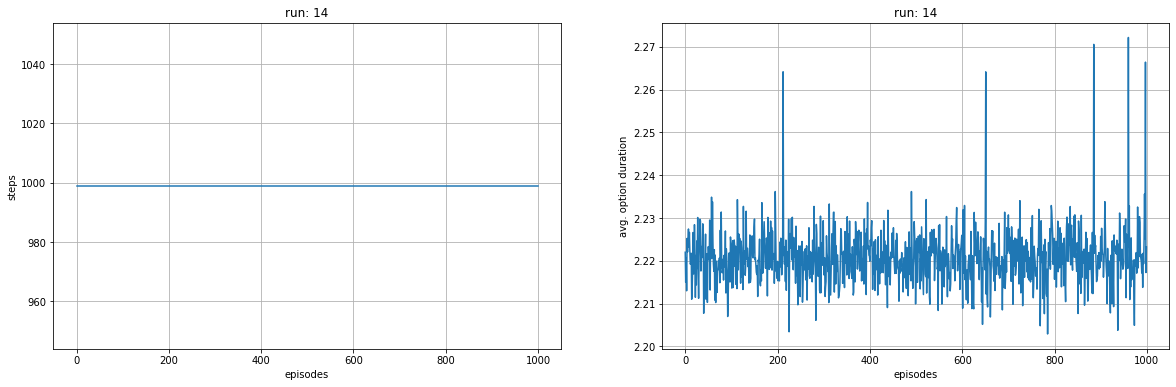

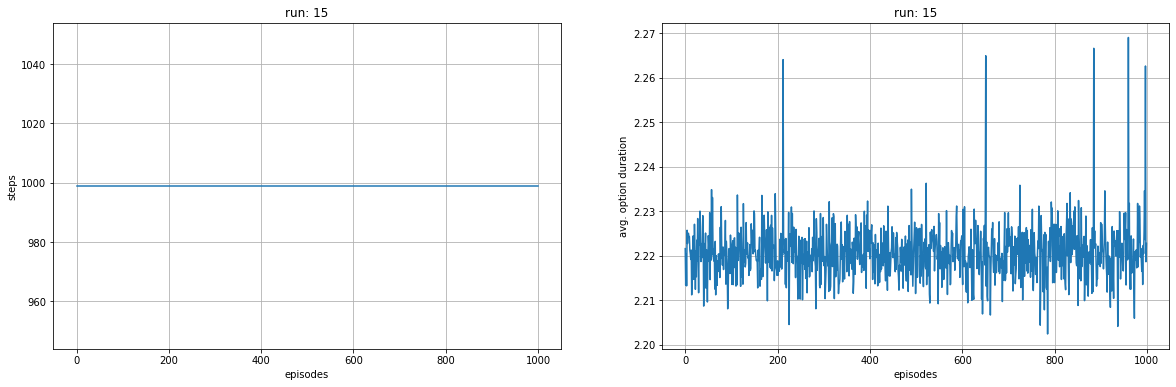

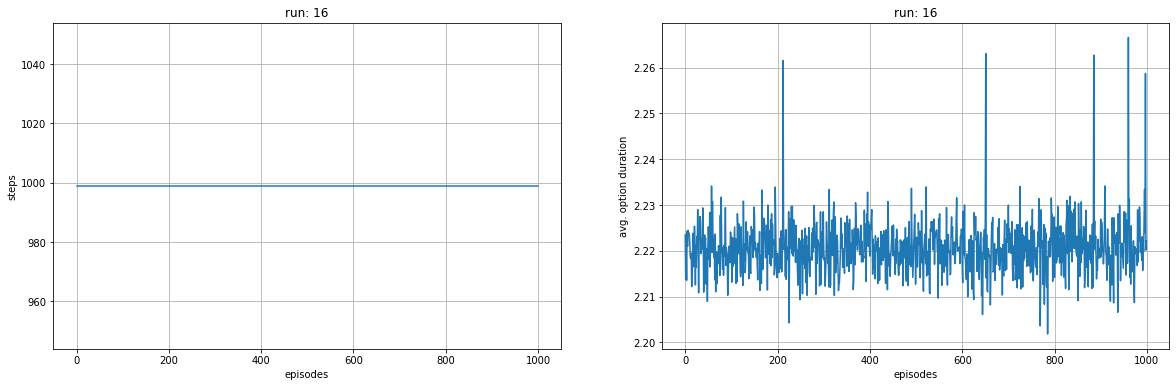

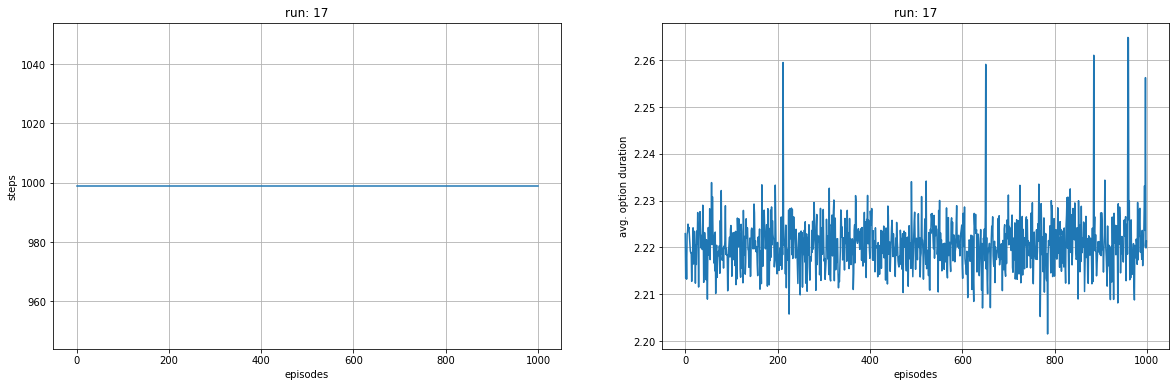

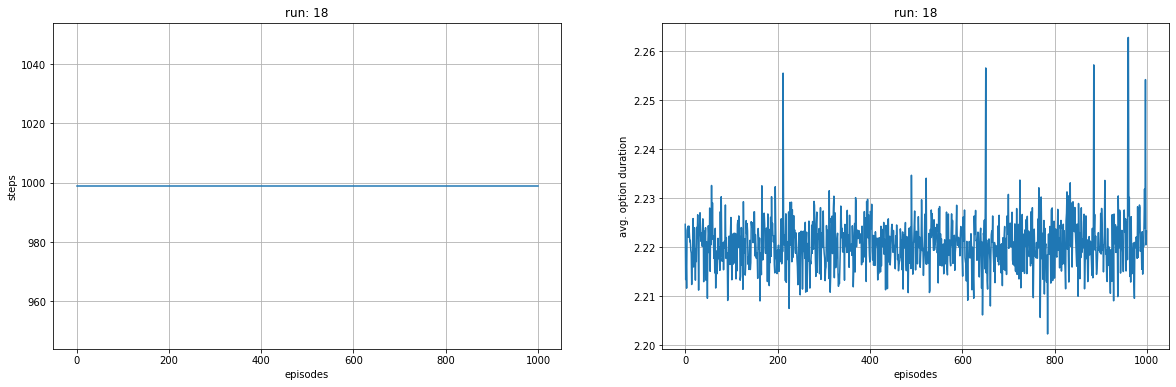

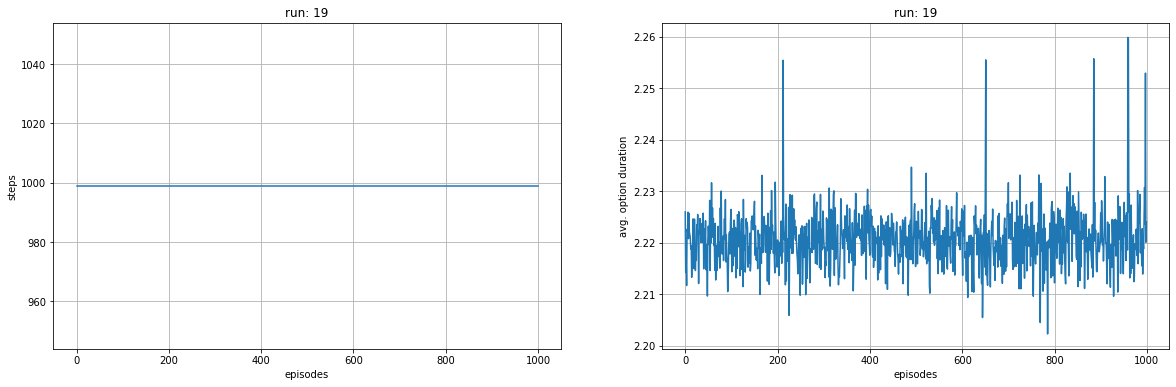

In [8]:
from scipy.special import logsumexp, expit
# Train Agent
#take random state
rng = np.random.RandomState(1234)

# History of steps and average durations
history = np.zeros((nruns, nepisodes, 2))

option_terminations_list = []

pbar = tqdm(total=nruns*nepisodes*nsteps)

for run in range(nruns):
    nstates = np.prod(env.vector_observation_dims)
    nactions = env.action_space.n

   
    # Following three belong to the Actor

    # 1. The intra-option policies - linear softmax functions
    option_policies = [SoftmaxPolicy(rng, lr_intra, nstates, nactions, temperature) for _ in range(noptions)]

    # 2. The termination function - linear sigmoid function
    option_terminations = [SigmoidTermination(rng, lr_term, nstates) for _ in range(noptions)]


    # 3. The epsilon-greedy policy over options
    policy_over_options = EpsGreedyPolicy(rng, nstates, noptions, epsilon)

    # Critic
    critic = Critic(lr_critic, discount, policy_over_options.Q_Omega_table, nstates, noptions, nactions)

    c = 0
    for episode in range(nepisodes):
        state = env.reset()
        state = tuple_to_index(state['taxi_0'],env)
        option = policy_over_options.sample(state)
        # hardcoding actions according to options
        action = option_policies[option].sample(state)

        critic.cache(state, option, action)

        duration = 1
        option_switches = 0
        avg_duration = 0.0
        action_dict = dict()
        action_dict['taxi_0'] = action

        for step in range(nsteps):
            state, reward, done, _ = env.step(action_dict)
            #env.render()
            state = tuple_to_index(state['taxi_0'],env)
            reward = reward['taxi_0']

            # Termination might occur upon entering new state (if this is a terminal state we are looking for a new option)
            if option_terminations[option].sample(state):
                option = policy_over_options.sample(state)
                option_switches += 1
                avg_duration += (1.0/option_switches)*(duration - avg_duration)
                duration = 1
            
            #if the state is not terminal we are choosing the action according to our option policy 
            action = option_policies[option].sample(state)
            
            # Critic update, we are constating the reward of the action and we update the option-state value at the higer level  
            critic.update_Qs(state, option, action, reward, done, option_terminations)
            
            # Intra-option policy update with baseline
            #we update the action-state value at the lower level for this action
            Q_U = critic.Q_U(state, option, action)
            #We see how choosing this action was a good idea 
            Q_U = Q_U - critic.Q_Omega(state, option)
            #we update the policy of the action in the option policy 
            option_policies[option].update(state, action, Q_U)
            
            # Termination condition update
            option_terminations[option].update(state, critic.A_Omega(state, option))
            
            duration += 1
            
            pbar.update()

            if done==True:
                break

        history[run, episode, 0] = step
        history[run, episode, 1] = avg_duration

    option_terminations_list.append(option_terminations)

#Plot stuff
    plt.figure(figsize=(20, 6))
    plt.subplot(121)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('steps')
    plt.plot(np.mean(history[:run + 1, :, 0], axis=0))
    plt.grid(True)
    plt.subplot(122)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('avg. option duration')
    plt.plot(np.mean(history[:run + 1, :, 1], axis=0))
    plt.grid(True)
    plt.show()

We see that the average duration of an option is starting equally for everyone at the begining, but after training the option duration is decresasing due to the optimization of the intra option policy. 

In [9]:
for run in range(nruns):
    
    #gives for every state-options a termination 
    termination_maps = [[0]*nstates for _ in range(noptions)]

    for option in range(noptions):
        for i in range(nstates):
            state = i
            if termination_maps[option][i] == 0:
                termination_maps[option][i] = option_terminations_list[run][option].pmf(state)

In [10]:
from IPython.display import clear_output
import time
# Test Agent
nsteps = 100
nepisodes = 10000
# Turn off exploration while testing
policy_over_options.epsilon = 0
for option in range(noptions):
    option_policies[option].temperature = 1e-10

env = MultiTaxiEnv()
env.reset()

rng = np.random.RandomState(1234)

try:
    for episode in range(nepisodes):
        state = env.reset()
        env.render()
        s = tuple_to_index(state['taxi_0'],env)

        option = policy_over_options.sample(s)

        for step in range(nsteps):

            action = option_policies[option].sample(s)
            action_dict = dict()
            action_dict['taxi_0'] = action
            state, reward, done, _ = env.step(action_dict)
            s = tuple_to_index(state['taxi_0'],env)
            time.sleep(0.2)
            clear_output(wait=True)
            env.render()

            # Termination might occur upon entering new state
            if option_terminations[option].sample(s):
                option = policy_over_options.sample(s)

            if done==True:
                time.sleep(0.2)
                clear_output(wait=True)
                print('goal reached')
                break
            print(f'episode {episode + 1}/{nepisodes}')
            print(f'step {step + 1}/{nsteps}')
    print('done')
except KeyboardInterrupt:
    print('User interrupt')
     

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : :D: : :P| : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3,2), Collided: False
Passenger1: Location: (3, 5), Destination: (3, 2)
Done: False, {'taxi_0': False, '__all__': False}
Passengers Status's: [2]
episode 1/10000
step 49/100
User interrupt
